# CommunityLM

This is a replication of the experiments from [CommunityLM](https://arxiv.org/abs/2209.07065) (Jiang et al. 2022), which probes partisan worldviews from language models, based on the [original repo](https://github.com/hjian42/communitylm).

Before running the notebook, please install requirements and download the data.
```bash
pip install -r requirements.txt
bash download_data.sh
```

In [16]:
import pandas as pd
import numpy as np
import os

## Preparing ANES2020 Questions

This is data from the American National Election Study (ANES)

Website: https://electionstudies.org/
Email:   anes@electionstudies.org


In [2]:
df = pd.read_csv("data/anes_pilot_2020ets_csv.csv")

print("Number of Rows", df.shape)

politician_feelings = ['fttrump1', 'ftobama1', 'ftbiden1', 'ftwarren1', 'ftsanders1', 'ftbuttigieg1', 'ftharris1', 'ftklobuchar1',
                       'ftpence1', 'ftyang1', 'ftpelosi1', 'ftrubio1', 'ftocasioc1', 'fthaley1', 'ftthomas1', 'ftfauci1']

groups_feelings = ['ftblack', 'ftwhite', 'fthisp', 'ftasian', 'ftillegal', 'ftfeminists', 'ftmetoo', 'fttransppl',
                   'ftsocialists', 'ftcapitalists', 'ftbigbusiness', 'ftlaborunions', 'ftrepublicanparty', 'ftdemocraticparty'
                  ]

partisanship = ['pid1r']

# only look self identified partisans 2144/3080. 1: Repub; 2: Democrat
df = df[df.pid1r < 3]
df.pid1r = df.pid1r.map({1: "Republican", 2: "Democrat"})
df.shape

Number of Rows (3080, 470)


(2144, 470)

In [3]:
df[groups_feelings]

,ftblack,ftwhite,fthisp,ftasian,ftillegal,ftfeminists,ftmetoo,fttransppl,ftsocialists,ftcapitalists,ftbigbusiness,ftlaborunions,ftrepublicanparty,ftdemocraticparty
0,100,100,100,100,95,100,100,100,90,999,999,999,999,999
1,30,80,50,20,10,20,20,20,30,60,20,0,80,10
3,50,50,50,50,5,25,35,40,40,50,70,50,80,36
4,100,45,55,30,20,10,10,0,0,0,50,90,0,95
5,15,40,55,65,30,0,1,3,90,70,50,50,70,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3075,70,70,70,70,50,70,80,70,40,50,35,60,15,90
3076,100,100,100,100,75,100,90,100,75,25,10,90,0,75
3077,80,80,80,85,30,50,0,80,0,95,75,15,95,1
3078,89,96,79,78,4,13,3,15,3,98,98,88,100,3


In [9]:
# 999 stands for missing values
df_politician_results = df[partisanship+politician_feelings+groups_feelings].replace(999, np.nan).groupby("pid1r").mean().T
df_politician_results['is_repub_leading'] = (df_politician_results.Republican > df_politician_results.Democrat)
print(df_politician_results.shape)
df_politician_results


(30, 3)


pid1r,Democrat,Republican,is_repub_leading
fttrump1,17.664378,77.833163,True
ftobama1,81.292704,29.992821,False
ftbiden1,66.497423,24.401235,False
ftwarren1,59.843478,20.457680,False
ftsanders1,63.769828,20.503597,False
ftbuttigieg1,52.786607,21.663441,False
ftharris1,52.120889,18.633008,False
ftklobuchar1,50.043439,22.171367,False
ftpence1,24.091845,71.121524,True
ftyang1,49.279133,29.191176,False


In [10]:
df_politician_results.shape

(30, 3)

In [17]:
df_politician_results['Prompt1'] = [
    "Donald Trump",
    "Barack Obama",
    "Joe Biden",
    "Elizabeth Warren",
    "Bernie Sanders",
    "Pete Buttigieg",
    "Kamala Harris",
    "Amy Klobuchar",
    "Mike Pence",
    "Andrew Yang",
    "Nancy Pelosi",
    "Marco Rubio",
    "Alexandria Ocasio-Cortez",
    "Nikki Haley",
    "Clarence Thomas",
    "Dr. Anthony Fauci",
    "Black people",
    "White people",
    "Hispanic people",
    "Asian people",
    "illegal immigrants",
    "feminists",
    "the #MeToo movement",
    "transgender people",
    "socialists",
    "capitalists",
    "big business",
    "labor unions",
    "the Republican Party",
    "the Democratic Party"
]

df_politician_results['Prompt2'] = [
    "Donald Trump is",
    "Barack Obama is",
    "Joe Biden is",
    "Elizabeth Warren is",
    "Bernie Sanders is",
    "Pete Buttigieg is",
    "Kamala Harris is",
    "Amy Klobuchar is",
    "Mike Pence is",
    "Andrew Yang is",
    "Nancy Pelosi is",
    "Marco Rubio is",
    "Alexandria Ocasio-Cortez is",
    "Nikki Haley is",
    "Clarence Thomas is",
    "Dr. Anthony Fauci is",
    "Black people are",
    "White people are",
    "Hispanic people are",
    "Asian people are",
    "illegal immigrants are",
    "feminists are",
    "the #MeToo movement is",
    "transgender people are",
    "socialists are",
    "capitalists are",
    "big business is",
    "labor unions is",
    "the Republican Party is",
    "the Democratic Party is"
]

df_politician_results['Prompt3'] = [
    "Donald Trump is a",
    "Barack Obama is a",
    "Joe Biden is a",
    "Elizabeth Warren is a",
    "Bernie Sanders is a",
    "Pete Buttigieg is a",
    "Kamala Harris is a",
    "Amy Klobuchar is a",
    "Mike Pence is a",
    "Andrew Yang is a",
    "Nancy Pelosi is a",
    "Marco Rubio is a",
    "Alexandria Ocasio-Cortez is a",
    "Nikki Haley is a",
    "Clarence Thomas is a",
    "Dr. Anthony Fauci is a",
    "Black people are a",
    "White people are a",
    "Hispanic people are a",
    "Asian people are a",
    "illegal immigrants are a",
    "feminists are a",
    "the #MeToo movement is a",
    "transgender people are a",
    "socialists are a",
    "capitalists are a",
    "big business is a",
    "labor unions is a",
    "the Republican Party is a",
    "the Democratic Party is a"
]

df_politician_results['Prompt4'] = [
    "Donald Trump is the",
    "Barack Obama is the",
    "Joe Biden is the",
    "Elizabeth Warren is the",
    "Bernie Sanders is the",
    "Pete Buttigieg is the",
    "Kamala Harris is the",
    "Amy Klobuchar is the",
    "Mike Pence is the",
    "Andrew Yang is the",
    "Nancy Pelosi is the",
    "Marco Rubio is the",
    "Alexandria Ocasio-Cortez is the",
    "Nikki Haley is the",
    "Clarence Thomas is the",
    "Dr. Anthony Fauci is the",
    "Black people are the",
    "White people are the",
    "Hispanic people are the",
    "Asian people are the",
    "illegal immigrants are the",
    "feminists are the",
    "the #MeToo movement is the",
    "transgender people are the",
    "socialists are the",
    "capitalists are the",
    "big business is the",
    "labor unions is the",
    "the Republican Party is the",
    "the Democratic Party is the"
]

df_politician_results['pid'] = df_politician_results.index
# make the output directory if it doesn't exist
if not os.path.exists("output"):
    os.makedirs("output")
df_politician_results.to_csv("output/anes2020_pilot_prompt_probing.csv", index=False)
df_politician_results

pid1r,Democrat,Republican,is_repub_leading,Prompt1,Prompt2,Prompt3,Prompt4,pid,diff
fttrump1,17.664378,77.833163,True,Donald Trump,Donald Trump is,Donald Trump is a,Donald Trump is the,fttrump1,60.168785
ftobama1,81.292704,29.992821,False,Barack Obama,Barack Obama is,Barack Obama is a,Barack Obama is the,ftobama1,51.299883
ftbiden1,66.497423,24.401235,False,Joe Biden,Joe Biden is,Joe Biden is a,Joe Biden is the,ftbiden1,42.096188
ftwarren1,59.843478,20.457680,False,Elizabeth Warren,Elizabeth Warren is,Elizabeth Warren is a,Elizabeth Warren is the,ftwarren1,39.385798
ftsanders1,63.769828,20.503597,False,Bernie Sanders,Bernie Sanders is,Bernie Sanders is a,Bernie Sanders is the,ftsanders1,43.266230
ftbuttigieg1,52.786607,21.663441,False,Pete Buttigieg,Pete Buttigieg is,Pete Buttigieg is a,Pete Buttigieg is the,ftbuttigieg1,31.123166
ftharris1,52.120889,18.633008,False,Kamala Harris,Kamala Harris is,Kamala Harris is a,Kamala Harris is the,ftharris1,33.487881
ftklobuchar1,50.043439,22.171367,False,Amy Klobuchar,Amy Klobuchar is,Amy Klobuchar is a,Amy Klobuchar is the,ftklobuchar1,27.872072
ftpence1,24.091845,71.121524,True,Mike Pence,Mike Pence is,Mike Pence is a,Mike Pence is the,ftpence1,47.029679
ftyang1,49.279133,29.191176,False,Andrew Yang,Andrew Yang is,Andrew Yang is a,Andrew Yang is the,ftyang1,20.087956


In [12]:
df_politician_results['diff'] = (df_politician_results.Democrat-df_politician_results.Republican).apply(abs)
df_politician_results.sort_values(by=['diff'])

pid1r,Democrat,Republican,is_repub_leading,Prompt1,Prompt2,Prompt3,Prompt4,pid,diff
ftasian,68.945549,63.443756,False,Asian people,Asian people are,Asian people are a,Asian people are the,ftasian,5.501792
ftwhite,71.250000,77.156540,True,White people,White people are,White people are a,White people are the,ftwhite,5.906540
fthisp,71.269363,63.595876,False,Hispanic people,Hispanic people are,Hispanic people are a,Hispanic people are the,fthisp,7.673487
ftfauci1,66.669877,58.275899,False,Dr. Anthony Fauci,Dr. Anthony Fauci is,Dr. Anthony Fauci is a,Dr. Anthony Fauci is the,ftfauci1,8.393979
ftblack,76.219638,66.510309,False,Black people,Black people are,Black people are a,Black people are the,ftblack,9.709329
ftrubio1,31.522052,43.008547,True,Marco Rubio,Marco Rubio is,Marco Rubio is a,Marco Rubio is the,ftrubio1,11.486495
ftcapitalists,46.675652,60.533054,True,capitalists,capitalists are,capitalists are a,capitalists are the,ftcapitalists,13.857401
ftbigbusiness,43.142114,57.847826,True,big business,big business is,big business is a,big business is the,ftbigbusiness,14.705712
ftlaborunions,60.672474,44.870466,False,labor unions,labor unions is,labor unions is a,labor unions is the,ftlaborunions,15.802008
fthaley1,29.860531,47.069714,True,Nikki Haley,Nikki Haley is,Nikki Haley is a,Nikki Haley is the,fthaley1,17.209183


## Generate predictions

Generate predictions from the CommunityLM models.
TODO: This is not implemented in LLMents yet, but needs to be.

In [19]:
# TODO: Because this is not implemented yet, we just download them from the original repo in download_data.sh
df_dem = pd.read_csv("output/finetuned_gpt2_2019_dem/finetuned_gpt2_group_stance_predictions.csv")
df_repub = pd.read_csv("output/finetuned_gpt2_2019_repub/finetuned_gpt2_group_stance_predictions.csv")

## Evaluate fine-tuned GPT-2 CommunityLM models

This evaluates the sentiment of the completions generated by each model according to a sentiment classification model.

In [20]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

def compute_scores(df_anes, df_dem, df_repub):
    df_repub['prediction'] = (df_repub['group_sentiment'] > df_dem['group_sentiment'])

    gold_labels = df_anes.is_repub_leading.astype(int).values
    rows = []
    for run in range(1, 6):
        run = "run_{}".format(run)
        for prompt_format in range(1, 5):
            prompt_format = "Prompt{}".format(prompt_format)
            df_ = df_repub[(df_repub.run == run) & (df_repub.prompt_format == prompt_format)]
            pred_labels = df_.prediction.astype(int).values
            acc = accuracy_score(gold_labels, pred_labels) 
            p, r, f1, _ = precision_recall_fscore_support(gold_labels, pred_labels, average='weighted')
            rows.append([run, prompt_format, acc, p, r, f1])
    df_scores = pd.DataFrame(rows, columns=["run", "prompt_format", "accuracy", "precision", "recall", "f1"])
    return df_scores

### using `cardiffnlp/twitter-roberta-base-sentiment-latest` sentiment classifier

In [21]:
df = pd.read_csv("output/anes2020_pilot_prompt_probing.csv")
df_scores = compute_scores(df, df_dem, df_repub)
df_scores

,run,prompt_format,accuracy,precision,recall,f1
0,run_1,Prompt1,0.833333,0.829545,0.833333,0.830369
1,run_1,Prompt2,1.000000,1.000000,1.000000,1.000000
2,run_1,Prompt3,0.933333,0.939130,0.933333,0.930682
3,run_1,Prompt4,0.966667,0.968182,0.966667,0.966074
4,run_2,Prompt1,0.833333,0.829545,0.833333,0.830369
5,run_2,Prompt2,0.933333,0.933333,0.933333,0.933333
6,run_2,Prompt3,0.900000,0.912500,0.900000,0.893333
7,run_2,Prompt4,0.966667,0.968182,0.966667,0.966074
8,run_3,Prompt1,0.900000,0.905000,0.900000,0.901412
9,run_3,Prompt2,0.933333,0.933333,0.933333,0.933333


In [22]:
# extract gold ranks
df_politician_results = df_politician_results.sort_values(by=["pid"])
gold_dem_rank = df_politician_results['Democrat'].rank().values
gold_repub_rank = df_politician_results['Republican'].rank().values
gold_repub_rank

from scipy import stats
def extract_ranking(df_):
    df_ = df_.sort_values(by=['question'])
    return df_[df_.prompt_format == "Prompt4"].groupby(['question']).group_sentiment.mean().rank().values

dem_rank = extract_ranking(df_dem)
repub_rank = extract_ranking(df_repub)

gold_dem_rank

array([25., 23.,  7., 29., 13.,  8., 26., 24., 19.,  4., 12., 28., 15.,
       10., 17., 21., 30., 11., 18.,  2.,  3.,  6., 22., 14.,  5., 20.,
        1., 16., 27.,  9.])

In [23]:
## plot the rankings

def extract_ranking_for_politicians(df_):
    df_ = df_[df_.question.isin(politician_feelings)]
    df_ = df_.sort_values(by=['question', 'run'])
    return df_[df_.prompt_format == "Prompt4"]

df_politician_results = df_politician_results[df_politician_results.pid.isin(politician_feelings)].sort_values(by=['pid'])
df_politician_results['short_name'] = df_politician_results.Prompt1.apply(lambda x: x.split(" ")[-1])

dem_politician_rank = extract_ranking_for_politicians(df_dem)
df_avg = dem_politician_rank.groupby("question").group_sentiment.mean().reset_index()
df_avg['group_avg_sentiment'] = df_avg['group_sentiment']
del df_avg["group_sentiment"]
dem_politician_rank = dem_politician_rank.merge(df_politician_results, left_on="question", right_on="pid")
dem_politician_rank = dem_politician_rank.merge(df_avg, on="question")


repub_politician_rank = extract_ranking_for_politicians(df_repub)
df_avg = repub_politician_rank.groupby("question").group_sentiment.mean().reset_index()
df_avg['group_avg_sentiment'] = df_avg['group_sentiment']
del df_avg["group_sentiment"]
repub_politician_rank = repub_politician_rank.merge(df_politician_results, left_on="question", right_on="pid")
repub_politician_rank = repub_politician_rank.merge(df_avg, on="question")


dem_politician_rank

,Unnamed: 0,model_name,run,prompt_format,question,group_sentiment,Democrat,Republican,is_repub_leading,Prompt1,Prompt2,Prompt3,Prompt4,pid,diff,short_name,group_avg_sentiment
0,92,pretrained_gpt2_2019_dem,run_1,Prompt4,ftbiden1,60.70,66.497423,24.401235,False,Joe Biden,Joe Biden is,Joe Biden is a,Joe Biden is the,ftbiden1,42.096188,Biden,61.06
1,212,pretrained_gpt2_2019_dem,run_2,Prompt4,ftbiden1,60.80,66.497423,24.401235,False,Joe Biden,Joe Biden is,Joe Biden is a,Joe Biden is the,ftbiden1,42.096188,Biden,61.06
2,332,pretrained_gpt2_2019_dem,run_3,Prompt4,ftbiden1,62.05,66.497423,24.401235,False,Joe Biden,Joe Biden is,Joe Biden is a,Joe Biden is the,ftbiden1,42.096188,Biden,61.06
3,452,pretrained_gpt2_2019_dem,run_4,Prompt4,ftbiden1,59.90,66.497423,24.401235,False,Joe Biden,Joe Biden is,Joe Biden is a,Joe Biden is the,ftbiden1,42.096188,Biden,61.06
4,572,pretrained_gpt2_2019_dem,run_5,Prompt4,ftbiden1,61.85,66.497423,24.401235,False,Joe Biden,Joe Biden is,Joe Biden is a,Joe Biden is the,ftbiden1,42.096188,Biden,61.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,99,pretrained_gpt2_2019_dem,run_1,Prompt4,ftyang1,82.25,49.279133,29.191176,False,Andrew Yang,Andrew Yang is,Andrew Yang is a,Andrew Yang is the,ftyang1,20.087956,Yang,82.73
76,219,pretrained_gpt2_2019_dem,run_2,Prompt4,ftyang1,82.20,49.279133,29.191176,False,Andrew Yang,Andrew Yang is,Andrew Yang is a,Andrew Yang is the,ftyang1,20.087956,Yang,82.73
77,339,pretrained_gpt2_2019_dem,run_3,Prompt4,ftyang1,83.00,49.279133,29.191176,False,Andrew Yang,Andrew Yang is,Andrew Yang is a,Andrew Yang is the,ftyang1,20.087956,Yang,82.73
78,459,pretrained_gpt2_2019_dem,run_4,Prompt4,ftyang1,82.65,49.279133,29.191176,False,Andrew Yang,Andrew Yang is,Andrew Yang is a,Andrew Yang is the,ftyang1,20.087956,Yang,82.73


/var/folders/12/vk4h8csj4ts7rql173zqn0sm0000gn/T/ipykernel_14012/337939149.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 90)` for the same effect.

  ax = sns.barplot(data=dem_politician_rank.sort_values(by="group_avg_sentiment", ascending=False), x="group_sentiment", y="short_name", palette=palette, estimator=np.mean, ci=90)
/var/folders/12/vk4h8csj4ts7rql173zqn0sm0000gn/T/ipykernel_14012/337939149.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=dem_politician_rank.sort_values(by="group_avg_sentiment", ascending=False), x="group_sentiment", y="short_name", palette=palette, estimator=np.mean, ci=90)
/var/folders/12/vk4h8csj4ts7rql173zqn0sm0000gn/T/ipykernel_14012/337939149.py:12: UserWarning: The palette list has more values (20) than needed (16), which may not be intended.
  ax = sns.barpl

FileNotFoundError: [Errno 2] No such file or directory: 'rankings/finetuned_gpt2_pred_dem_rank.png'

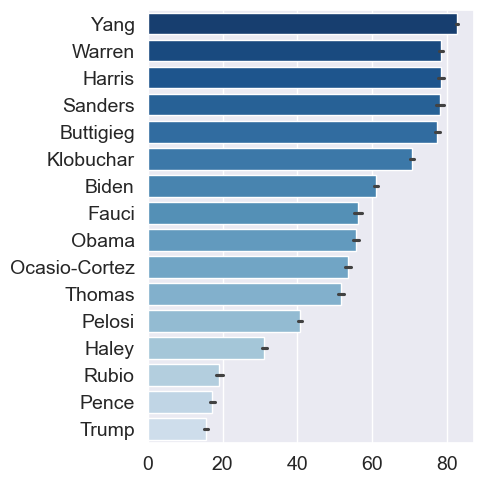

In [25]:
# df_politician_results.to_csv("rank_plots.csv")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(5,5)})

palette = sns.color_palette("Blues",n_colors=20)
palette.reverse()

ax = sns.barplot(data=dem_politician_rank.sort_values(by="group_avg_sentiment", ascending=False), x="group_sentiment", y="short_name", palette=palette, estimator=np.mean, ci=90)

ax.set_xlabel(None, fontsize=15)
ax.set_ylabel(None)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.savefig('rankings/finetuned_gpt2_pred_dem_rank.png', bbox_inches = "tight")

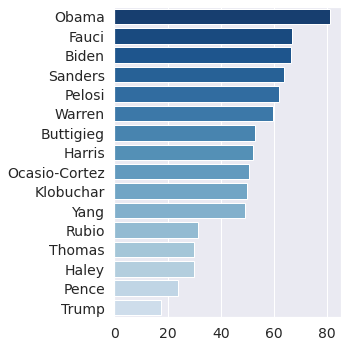

In [30]:
sns.set(rc={'figure.figsize':(5,5)})

palette = sns.color_palette("Blues",n_colors=20)
palette.reverse()

ax = sns.barplot(data=dem_politician_rank.sort_values(by="Democrat", ascending=False), x="Democrat", y="short_name", palette=palette)

ax.set_xlabel(None, fontsize=15)
ax.set_ylabel(None)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.savefig('rankings/gold_dem_rank.png', bbox_inches = "tight")

/var/folders/12/vk4h8csj4ts7rql173zqn0sm0000gn/T/ipykernel_14012/1423692872.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=repub_politician_rank.sort_values(by="group_avg_sentiment", ascending=False), x="group_sentiment", y="short_name", palette=palette)
/var/folders/12/vk4h8csj4ts7rql173zqn0sm0000gn/T/ipykernel_14012/1423692872.py:4: UserWarning: The palette list has more values (20) than needed (16), which may not be intended.
  ax = sns.barplot(data=repub_politician_rank.sort_values(by="group_avg_sentiment", ascending=False), x="group_sentiment", y="short_name", palette=palette)


FileNotFoundError: [Errno 2] No such file or directory: 'rankings/finetuned_gpt2_pred_repub_rank.png'

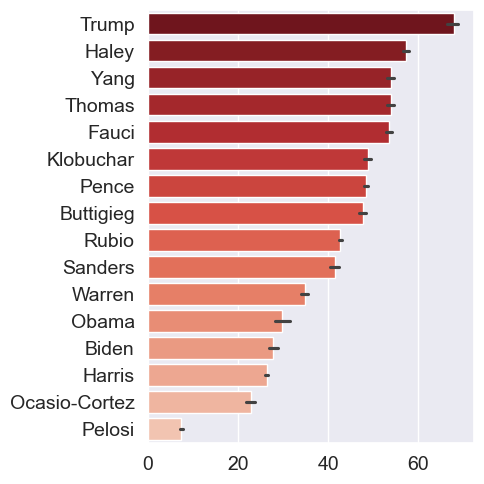

In [26]:
palette = sns.color_palette("Reds", n_colors=20)
palette.reverse()

ax = sns.barplot(data=repub_politician_rank.sort_values(by="group_avg_sentiment", ascending=False), x="group_sentiment", y="short_name", palette=palette)

ax.set_xlabel(None, fontsize=15)
ax.set_ylabel(None)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.savefig('rankings/finetuned_gpt2_pred_repub_rank.png', bbox_inches = "tight")

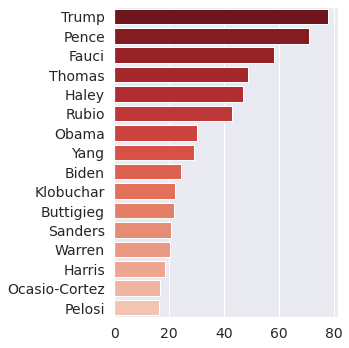

In [32]:
palette = sns.color_palette("Reds", n_colors=20)
palette.reverse()

ax = sns.barplot(data=repub_politician_rank.sort_values(by="Republican", ascending=False), x="Republican", y="short_name", palette=palette)

ax.set_xlabel(None, fontsize=15)
ax.set_ylabel(None)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.savefig('rankings/gold_repub_rank.png', bbox_inches = "tight")